In [69]:
!pip install pycocotools
from collections import defaultdict, deque
import datetime
import pickle
import time

import torch
import torch.distributed as dist

import errno
import os


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)
            #print("V is {}\nK is {}".format(v,k))

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter
        #print("My name is adadd",meter, name)

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

import json
import tempfile

import numpy as np
import copy
import time
import torch
import torch._six

from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import pycocotools.mask as mask_util

from collections import defaultdict


class CocoEvaluator(object):
    def __init__(self, coco_gt, iou_types):
        assert isinstance(iou_types, (list, tuple))
        coco_gt = copy.deepcopy(coco_gt)
        self.coco_gt = coco_gt

        self.iou_types = iou_types
        self.coco_eval = {}
        for iou_type in iou_types:
            self.coco_eval[iou_type] = COCOeval(coco_gt, iouType=iou_type)

        self.img_ids = []
        self.eval_imgs = {k: [] for k in iou_types}

    def update(self, predictions):
        img_ids = list(np.unique(list(predictions.keys())))
        self.img_ids.extend(img_ids)

        for iou_type in self.iou_types:
            results = self.prepare(predictions, iou_type)
            coco_dt = loadRes(self.coco_gt, results) if results else COCO()
            coco_eval = self.coco_eval[iou_type]

            coco_eval.cocoDt = coco_dt
            coco_eval.params.imgIds = list(img_ids)
            img_ids, eval_imgs = evaluate(coco_eval)

            self.eval_imgs[iou_type].append(eval_imgs)

    def synchronize_between_processes(self):
        for iou_type in self.iou_types:
            self.eval_imgs[iou_type] = np.concatenate(self.eval_imgs[iou_type], 2)
            create_common_coco_eval(self.coco_eval[iou_type], self.img_ids, self.eval_imgs[iou_type])

    def accumulate(self):
        for coco_eval in self.coco_eval.values():
            coco_eval.accumulate()

    def summarize(self):
        for iou_type, coco_eval in self.coco_eval.items():
            print("IoU metric: {}".format(iou_type))
            coco_eval.summarize()

    def prepare(self, predictions, iou_type):
        if iou_type == "bbox":
            return self.prepare_for_coco_detection(predictions)
        elif iou_type == "segm":
            return self.prepare_for_coco_segmentation(predictions)
        elif iou_type == "keypoints":
            return self.prepare_for_coco_keypoint(predictions)
        else:
            raise ValueError("Unknown iou type {}".format(iou_type))

    def prepare_for_coco_detection(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "bbox": box,
                        "score": scores[k],
                    }
                    for k, box in enumerate(boxes)
                ]
            )
        return coco_results

    def prepare_for_coco_segmentation(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            scores = prediction["scores"]
            labels = prediction["labels"]
            masks = prediction["masks"]

            masks = masks > 0.5

            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()

            rles = [
                mask_util.encode(np.array(mask[0, :, :, np.newaxis], dtype=np.uint8, order="F"))[0]
                for mask in masks
            ]
            for rle in rles:
                rle["counts"] = rle["counts"].decode("utf-8")

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        "segmentation": rle,
                        "score": scores[k],
                    }
                    for k, rle in enumerate(rles)
                ]
            )
        return coco_results

    def prepare_for_coco_keypoint(self, predictions):
        coco_results = []
        for original_id, prediction in predictions.items():
            if len(prediction) == 0:
                continue

            boxes = prediction["boxes"]
            boxes = convert_to_xywh(boxes).tolist()
            scores = prediction["scores"].tolist()
            labels = prediction["labels"].tolist()
            keypoints = prediction["keypoints"]
            keypoints = keypoints.flatten(start_dim=1).tolist()

            coco_results.extend(
                [
                    {
                        "image_id": original_id,
                        "category_id": labels[k],
                        'keypoints': keypoint,
                        "score": scores[k],
                    }
                    for k, keypoint in enumerate(keypoints)
                ]
            )
        return coco_results


def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)


def merge(img_ids, eval_imgs):
    all_img_ids = all_gather(img_ids)
    all_eval_imgs = all_gather(eval_imgs)

    merged_img_ids = []
    for p in all_img_ids:
        merged_img_ids.extend(p)

    merged_eval_imgs = []
    for p in all_eval_imgs:
        merged_eval_imgs.append(p)

    merged_img_ids = np.array(merged_img_ids)
    merged_eval_imgs = np.concatenate(merged_eval_imgs, 2)

    # keep only unique (and in sorted order) images
    merged_img_ids, idx = np.unique(merged_img_ids, return_index=True)
    merged_eval_imgs = merged_eval_imgs[..., idx]

    return merged_img_ids, merged_eval_imgs


def create_common_coco_eval(coco_eval, img_ids, eval_imgs):
    img_ids, eval_imgs = merge(img_ids, eval_imgs)
    img_ids = list(img_ids)
    eval_imgs = list(eval_imgs.flatten())

    coco_eval.evalImgs = eval_imgs
    coco_eval.params.imgIds = img_ids
    coco_eval._paramsEval = copy.deepcopy(coco_eval.params)


#################################################################
# From pycocotools, just removed the prints and fixed
# a Python3 bug about unicode not defined
#################################################################

# Ideally, pycocotools wouldn't have hard-coded prints
# so that we could avoid copy-pasting those two functions

def createIndex(self):
    # create index
    # print('creating index...')
    anns, cats, imgs = {}, {}, {}
    imgToAnns, catToImgs = defaultdict(list), defaultdict(list)
    if 'annotations' in self.dataset:
        for ann in self.dataset['annotations']:
            imgToAnns[ann['image_id']].append(ann)
            anns[ann['id']] = ann

    if 'images' in self.dataset:
        for img in self.dataset['images']:
            imgs[img['id']] = img

    if 'categories' in self.dataset:
        for cat in self.dataset['categories']:
            cats[cat['id']] = cat

    if 'annotations' in self.dataset and 'categories' in self.dataset:
        for ann in self.dataset['annotations']:
            catToImgs[ann['category_id']].append(ann['image_id'])

    # print('index created!')

    # create class members
    self.anns = anns
    self.imgToAnns = imgToAnns
    self.catToImgs = catToImgs
    self.imgs = imgs
    self.cats = cats


maskUtils = mask_util


def loadRes(self, resFile):
    """
    Load result file and return a result api object.
    :param   resFile (str)     : file name of result file
    :return: res (obj)         : result api object
    """
    res = COCO()
    res.dataset['images'] = [img for img in self.dataset['images']]

    # print('Loading and preparing results...')
    # tic = time.time()
    if isinstance(resFile, torch._six.string_classes):
        anns = json.load(open(resFile))
    elif type(resFile) == np.ndarray:
        anns = self.loadNumpyAnnotations(resFile)
    else:
        anns = resFile
    assert type(anns) == list, 'results in not an array of objects'
    annsImgIds = [ann['image_id'] for ann in anns]
    assert set(annsImgIds) == (set(annsImgIds) & set(self.getImgIds())), \
        'Results do not correspond to current coco set'
    if 'caption' in anns[0]:
        imgIds = set([img['id'] for img in res.dataset['images']]) & set([ann['image_id'] for ann in anns])
        res.dataset['images'] = [img for img in res.dataset['images'] if img['id'] in imgIds]
        for id, ann in enumerate(anns):
            ann['id'] = id + 1
    elif 'bbox' in anns[0] and not anns[0]['bbox'] == []:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            bb = ann['bbox']
            x1, x2, y1, y2 = [bb[0], bb[0] + bb[2], bb[1], bb[1] + bb[3]]
            if 'segmentation' not in ann:
                ann['segmentation'] = [[x1, y1, x1, y2, x2, y2, x2, y1]]
            ann['area'] = bb[2] * bb[3]
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'segmentation' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            # now only support compressed RLE format as segmentation results
            ann['area'] = maskUtils.area(ann['segmentation'])
            if 'bbox' not in ann:
                ann['bbox'] = maskUtils.toBbox(ann['segmentation'])
            ann['id'] = id + 1
            ann['iscrowd'] = 0
    elif 'keypoints' in anns[0]:
        res.dataset['categories'] = copy.deepcopy(self.dataset['categories'])
        for id, ann in enumerate(anns):
            s = ann['keypoints']
            x = s[0::3]
            y = s[1::3]
            x1, x2, y1, y2 = np.min(x), np.max(x), np.min(y), np.max(y)
            ann['area'] = (x2 - x1) * (y2 - y1)
            ann['id'] = id + 1
            ann['bbox'] = [x1, y1, x2 - x1, y2 - y1]
    # print('DONE (t={:0.2f}s)'.format(time.time()- tic))

    res.dataset['annotations'] = anns
    createIndex(res)
    return res


def evaluate(self):
    '''
    Run per image evaluation on given images and store results (a list of dict) in self.evalImgs
    :return: None
    '''
    # tic = time.time()
    # print('Running per image evaluation...')
    p = self.params
    # add backward compatibility if useSegm is specified in params
    if p.useSegm is not None:
        p.iouType = 'segm' if p.useSegm == 1 else 'bbox'
        print('useSegm (deprecated) is not None. Running {} evaluation'.format(p.iouType))
    # print('Evaluate annotation type *{}*'.format(p.iouType))
    p.imgIds = list(np.unique(p.imgIds))
    if p.useCats:
        p.catIds = list(np.unique(p.catIds))
    p.maxDets = sorted(p.maxDets)
    self.params = p

    self._prepare()
    # loop through images, area range, max detection number
    catIds = p.catIds if p.useCats else [-1]

    if p.iouType == 'segm' or p.iouType == 'bbox':
        computeIoU = self.computeIoU
    elif p.iouType == 'keypoints':
        computeIoU = self.computeOks
    self.ious = {
        (imgId, catId): computeIoU(imgId, catId)
        for imgId in p.imgIds
        for catId in catIds}

    evaluateImg = self.evaluateImg
    maxDet = p.maxDets[-1]
    evalImgs = [
        evaluateImg(imgId, catId, areaRng, maxDet)
        for catId in catIds
        for areaRng in p.areaRng
        for imgId in p.imgIds
    ]
    # this is NOT in the pycocotools code, but could be done outside
    evalImgs = np.asarray(evalImgs).reshape(len(catIds), len(p.areaRng), len(p.imgIds))
    self._paramsEval = copy.deepcopy(self.params)
    # toc = time.time()
    # print('DONE (t={:0.2f}s).'.format(toc-tic))
    return p.imgIds, evalImgs

import copy
import os
from PIL import Image

import torch
import torch.utils.data
import torchvision

from pycocotools import mask as coco_mask
from pycocotools.coco import COCO

class FilterAndRemapCocoCategories(object):
    def __init__(self, categories, remap=True):
        self.categories = categories
        self.remap = remap

    def __call__(self, image, target):
        anno = target["annotations"]
        anno = [obj for obj in anno if obj["category_id"] in self.categories]
        if not self.remap:
            target["annotations"] = anno
            return image, target
        anno = copy.deepcopy(anno)
        for obj in anno:
            obj["category_id"] = self.categories.index(obj["category_id"])
        target["annotations"] = anno
        return image, target


def convert_coco_poly_to_mask(segmentations, height, width):
    masks = []
    for polygons in segmentations:
        rles = coco_mask.frPyObjects(polygons, height, width)
        mask = coco_mask.decode(rles)
        if len(mask.shape) < 3:
            mask = mask[..., None]
        mask = torch.as_tensor(mask, dtype=torch.uint8)
        mask = mask.any(dim=2)
        masks.append(mask)
    if masks:
        masks = torch.stack(masks, dim=0)
    else:
        masks = torch.zeros((0, height, width), dtype=torch.uint8)
    return masks


class ConvertCocoPolysToMask(object):
    def __call__(self, image, target):
        w, h = image.size

        image_id = target["image_id"]
        image_id = torch.tensor([image_id])

        anno = target["annotations"]

        anno = [obj for obj in anno if obj['iscrowd'] == 0]

        boxes = [obj["bbox"] for obj in anno]
        # guard against no boxes via resizing
        boxes = torch.as_tensor(boxes, dtype=torch.float32).reshape(-1, 4)
        boxes[:, 2:] += boxes[:, :2]
        boxes[:, 0::2].clamp_(min=0, max=w)
        boxes[:, 1::2].clamp_(min=0, max=h)

        classes = [obj["category_id"] for obj in anno]
        classes = torch.tensor(classes, dtype=torch.int64)

        segmentations = [obj["segmentation"] for obj in anno]
        masks = convert_coco_poly_to_mask(segmentations, h, w)

        keypoints = None
        if anno and "keypoints" in anno[0]:
            keypoints = [obj["keypoints"] for obj in anno]
            keypoints = torch.as_tensor(keypoints, dtype=torch.float32)
            num_keypoints = keypoints.shape[0]
            if num_keypoints:
                keypoints = keypoints.view(num_keypoints, -1, 3)

        keep = (boxes[:, 3] > boxes[:, 1]) & (boxes[:, 2] > boxes[:, 0])
        boxes = boxes[keep]
        classes = classes[keep]
        masks = masks[keep]
        if keypoints is not None:
            keypoints = keypoints[keep]

        target = {}
        target["boxes"] = boxes
        target["labels"] = classes
        target["masks"] = masks
        target["image_id"] = image_id
        if keypoints is not None:
            target["keypoints"] = keypoints

        # for conversion to coco api
        area = torch.tensor([obj["area"] for obj in anno])
        iscrowd = torch.tensor([obj["iscrowd"] for obj in anno])
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target


def _coco_remove_images_without_annotations(dataset, cat_list=None):
    def _has_only_empty_bbox(anno):
        return all(any(o <= 1 for o in obj["bbox"][2:]) for obj in anno)

    def _count_visible_keypoints(anno):
        return sum(sum(1 for v in ann["keypoints"][2::3] if v > 0) for ann in anno)

    min_keypoints_per_image = 10

    def _has_valid_annotation(anno):
        # if it's empty, there is no annotation
        if len(anno) == 0:
            return False
        # if all boxes have close to zero area, there is no annotation
        if _has_only_empty_bbox(anno):
            return False
        # keypoints task have a slight different critera for considering
        # if an annotation is valid
        if "keypoints" not in anno[0]:
            return True
        # for keypoint detection tasks, only consider valid images those
        # containing at least min_keypoints_per_image
        if _count_visible_keypoints(anno) >= min_keypoints_per_image:
            return True
        return False

    assert isinstance(dataset, torchvision.datasets.CocoDetection)
    ids = []
    for ds_idx, img_id in enumerate(dataset.ids):
        ann_ids = dataset.coco.getAnnIds(imgIds=img_id, iscrowd=None)
        anno = dataset.coco.loadAnns(ann_ids)
        if cat_list:
            anno = [obj for obj in anno if obj["category_id"] in cat_list]
        if _has_valid_annotation(anno):
            ids.append(ds_idx)

    dataset = torch.utils.data.Subset(dataset, ids)
    return dataset


def convert_to_coco_api(ds):
    coco_ds = COCO()
    # annotation IDs need to start at 1, not 0, see torchvision issue #1530
    ann_id = 1
    dataset = {'images': [], 'categories': [], 'annotations': []}
    categories = set()
    for img_idx in range(len(ds)):
        # find better way to get target
        # targets = ds.get_annotations(img_idx)
        img, targets = ds[img_idx]
        image_id = targets["image_id"].item()
        img_dict = {}
        img_dict['id'] = image_id
        img_dict['height'] = img.shape[-2]
        img_dict['width'] = img.shape[-1]
        dataset['images'].append(img_dict)
        bboxes = targets["boxes"]
        bboxes[:, 2:] -= bboxes[:, :2]
        bboxes = bboxes.tolist()
        labels = targets['labels'].tolist()
        areas = targets['area'].tolist()
        iscrowd = targets['iscrowd'].tolist()
        if 'masks' in targets:
            masks = targets['masks']
            # make masks Fortran contiguous for coco_mask
            masks = masks.permute(0, 2, 1).contiguous().permute(0, 2, 1)
        if 'keypoints' in targets:
            keypoints = targets['keypoints']
            keypoints = keypoints.reshape(keypoints.shape[0], -1).tolist()
        num_objs = len(bboxes)
        for i in range(num_objs):
            ann = {}
            ann['image_id'] = image_id
            ann['bbox'] = bboxes[i]
            ann['category_id'] = labels[i]
            categories.add(labels[i])
            ann['area'] = areas[i]
            ann['iscrowd'] = iscrowd[i]
            ann['id'] = ann_id
            if 'masks' in targets:
                ann["segmentation"] = coco_mask.encode(masks[i].numpy())
            if 'keypoints' in targets:
                ann['keypoints'] = keypoints[i]
                ann['num_keypoints'] = sum(k != 0 for k in keypoints[i][2::3])
            dataset['annotations'].append(ann)
            ann_id += 1
    dataset['categories'] = [{'id': i} for i in sorted(categories)]
    coco_ds.dataset = dataset
    coco_ds.createIndex()
    return coco_ds


def get_coco_api_from_dataset(dataset):
    for _ in range(10):
        if isinstance(dataset, torchvision.datasets.CocoDetection):
            break
        if isinstance(dataset, torch.utils.data.Subset):
            dataset = dataset.dataset
    if isinstance(dataset, torchvision.datasets.CocoDetection):
        return dataset.coco
    return convert_to_coco_api(dataset)


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, ann_file, transforms):
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        target = dict(image_id=image_id, annotations=target)
        if self._transforms is not None:
            img, target = self._transforms(img, target)
        return img, target


def get_coco(root, image_set, transforms, mode='instances'):
    anno_file_template = "{}_{}2017.json"
    PATHS = {
        "train": ("train2017", os.path.join("annotations", anno_file_template.format(mode, "train"))),
        "val": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val"))),
        # "train": ("val2017", os.path.join("annotations", anno_file_template.format(mode, "val")))
    }

    t = [ConvertCocoPolysToMask()]

    if transforms is not None:
        t.append(transforms)
    transforms = T.Compose(t)

    img_folder, ann_file = PATHS[image_set]
    img_folder = os.path.join(root, img_folder)
    ann_file = os.path.join(root, ann_file)

    dataset = CocoDetection(img_folder, ann_file, transforms=transforms)

    if image_set == "train":
        dataset = _coco_remove_images_without_annotations(dataset)
    return dataset


def get_coco_kp(root, image_set, transforms):
    return get_coco(root, image_set, transforms, mode="person_keypoints")

import random
import torch

from torchvision.transforms import functional as F


def _flip_coco_person_keypoints(kps, width):
    flip_inds = [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
    flipped_data = kps[:, flip_inds]
    flipped_data[..., 0] = width - flipped_data[..., 0]
    # Maintain COCO convention that if visibility == 0, then x, y = 0
    inds = flipped_data[..., 2] == 0
    flipped_data[inds] = 0
    return flipped_data


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            bbox = target["boxes"]
            bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
            target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator, metric_logger

In [70]:
import os
import numpy as np
import pandas as pd
from glob import glob
import cv2
import torch
from torch.utils import data
from PIL import Image
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

In [71]:
txt = np.genfromtxt('/kaggle/input/german-traffic-sign-detection/gt.txt',delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic):
        dic[img_name].append(target)
    else:
        dic[img_name] = [target]
print(dic['00001.ppm'])
print("Number of Images: " + str(len(dic)))

[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 506


{11: 39, 40: 17, 38: 115, 13: 119, 39: 10, 4: 70, 9: 67, 21: 10, 2: 111, 12: 101, 1: 84, 25: 34, 30: 29, 23: 31, 27: 6, 35: 30, 15: 18, 33: 31, 28: 22, 18: 53, 36: 18, 26: 23, 37: 2, 34: 24, 0: 7, 24: 6, 14: 49, 20: 24, 29: 6, 6: 33, 10: 167, 8: 135, 5: 69, 16: 11, 19: 3, 17: 75, 3: 35, 7: 69, 41: 13, 31: 2, 22: 22, 42: 15, 32: 5}


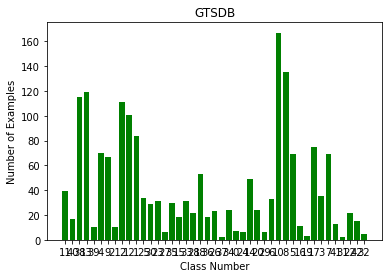

In [72]:
cls_lst = {}

for i in dic:
    for j in dic[i][:]:
        #print(len(dic[i]))
        for k in range(len(dic[i])):
            clss = dic[i][:][k][-1]
            if clss in cls_lst:
                cls_lst[clss] += 1
            else:
                cls_lst[clss] = 1
                
print(cls_lst)

xx = []
yy = []
for i in cls_lst:
    xx.append(str(i))
    yy.append(cls_lst[i])

x_pos = [i for i, _ in enumerate(xx)]

plt.bar(x_pos, yy, color='green')
plt.xlabel("Class Number")
plt.ylabel("Number of Examples")
plt.title("GTSDB")
#plt.figure(figsize=(30,30))
plt.xticks(x_pos, xx)

plt.show()

In [73]:
import shutil
from pathlib import Path

pt = glob('/kaggle/input/german-traffic-sign-detection/FullIJCNN2013/FullIJCNN2013/*.ppm')

len(pt)
#Copying into new directory
Path('/kaggle/working/annotated').mkdir(exist_ok=True)
for i in range(len(dic)):
    ofile = r'/kaggle/input/german-traffic-sign-detection/FullIJCNN2013/FullIJCNN2013/{}'.format(list(dic)[i])
    target = r'./annotated/{}'.format(list(dic)[i])
    shutil.copyfile(ofile, target)
#Check if len(dic) == number of images in folder
print(len(glob('./annotated/*.ppm')))
len(dic)

506


506

In [74]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "annotated"))))
 
    def __getitem__(self, idx):
        # Load image path
        img_path = os.path.join(self.root, "annotated", self.imgs[idx])
        #Load image as PIL
        img = Image.open(img_path).convert("RGB")        
        # Get objects in the image
        objects = dic[self.imgs[idx]]
        # Get bounding box coordinates for each object in image
        boxes = []
        labels = []
        for obj in objects:
            #print(idx, obj[-1], self.imgs)
            name = obj[-1]
            labels.append(np.int(name))
            #Get bounding box coordinates
            xmin = np.float(obj[0])
            ymin = np.float(obj[1])
            xmax = np.float(obj[2])
            ymax = np.float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [75]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # 50% chance of flipping horizontally
        transforms.append(RandomHorizontalFlip(0.5))
 
    return Compose(transforms)

In [80]:
import torch.nn as nn
os.environ['TORCH_HOME'] = './'

root = r'/kaggle/working/'

# Train on the GPU if available else CPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 44 classes = 43 + background
num_classes = 44
#Send the data to the myDataset class (Apply transformations, Get bbox, labels, objects)
dataset = myDataset(root, get_transform(train=True))
dataset_test = myDataset(root, get_transform(train=False))

# split the dataset in train and test set
# My dataset has 506 images, almost training validation 4:1
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
#collate_fn returns tuples of images and image annotations for every iteration.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, # num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, # num_workers=4,
    collate_fn=collate_fn)

# Define model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
# OR model = get_object_detection_model(num_classes)
#model = torch.load('./train150.pkl')

#Use specific GPUs:
# model = nn.DataParallel(model, device_ids=[0,1,2,3]) #Remove this line if not necessary.

# Move the model to device
model.to(device)

print("Model loaded")

Model loaded


In [83]:
from IPython.display import clear_output
import pickle


# Constructing the optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# Training for no. of Epochs
num_epochs = 10


losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []


for epoch in range(num_epochs):
    # Engine.py's train_one_epoch function takes both images and targets. to(device)
    # Metrics (metric_logger) was returned by train_one_epoch() in engine.py to get losses
    metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on the test dataset
    # _ gives coco_evaL obj from coco_eval.py from CocoEvaluator()
#     _, metric_logger = evaluate(model, data_loader_test, device)
    #Stat object is from pycocotools' self.stats in summarize()
    #https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
#     stat = _.coco_eval['bbox'].stats
    
    #Append all stats
#     stat0.append(stat[0])
#     stat1.append(stat[1])
#     stat2.append(stat[2])
#     stat3.append(stat[3])
#     stat4.append(stat[4])
#     stat5.append(stat[5])
#     stat6.append(stat[6])
#     stat7.append(stat[7])
#     stat8.append(stat[8])
#     stat9.append(stat[9])
#     stat10.append(stat[10])
#     stat11.append(stat[11])
    
    
    print('')
    print('==================================================')
    print('')

print("Done!")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt

Epoch: [0]  [  0/203]  eta: 0:01:15  lr: 0.000003  loss: 0.4386 (0.4386)  loss_classifier: 0.2456 (0.2456)  loss_box_reg: 0.1782 (0.1782)  loss_objectness: 0.0083 (0.0083)  loss_rpn_box_reg: 0.0066 (0.0066)  time: 0.3732  data: 0.0366  max mem: 3610
Epoch: [0]  [ 50/203]  eta: 0:00:55  lr: 0.000127  loss: 0.3037 (0.3468)  loss_classifier: 0.1706 (0.1931)  loss_box_reg: 0.0976 (0.1150)  loss_objectness: 0.0164 (0.0267)  loss_rpn_box_reg: 0.0099 (0.0119)  time: 0.3619  data: 0.0324  max mem: 3765
Epoch: [0]  [100/203]  eta: 0:00:37  lr: 0.000250  loss: 0.2921 (0.3423)  loss_classifier: 0.1802 (0.1936)  loss_box_reg: 0.0963 (0.1148)  loss_objectness: 0.0167 (0.0234)  loss_rpn_box_reg: 0.0047 (0.0105)  time: 0.3601  data: 0.0322  max mem: 3765
Epoch: [0]  [150/203]  eta: 0:00:19  lr: 0.000374  loss: 0.3046 (0.3337)  loss_classifier: 0.1753 (0.1893)  loss_box_reg: 0.1012 (0.1134)  loss_objectness: 0.0130 (0.0208)  loss_rpn_box_reg: 0.0072 (0.0102)  time: 0.3626  data: 0.0330  max mem: 3765


In [ ]:
r,c = 9,2
fig, ax = plt.subplots(nrows=r, ncols=c)
fig.set_figheight(40)
fig.set_figwidth(10)
fig.subplots_adjust(left=14,right=15, top=6, bottom=5, hspace=1, wspace=1)


ax1 = plt.subplot(r, c, 1)
ax1.set_title("Losses")
ax2 = plt.subplot(r, c, 2)
ax2.set_title("Loss Box Reg")
ax3 = plt.subplot(r, c, 3)
ax3.set_title("Loss RPN Box Reg")
ax4 = plt.subplot(r, c, 4)
ax4.set_title("Loss Classifier")
ax5 = plt.subplot(r, c, 5)
ax5.set_title("Loss Objectness")
ax6 = plt.subplot(r, c, 6)
ax6.set_title("(AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax7 = plt.subplot(r, c, 7)
ax7.set_title("(AP) @[ IoU=0.50      | area=   all | maxDets=100")
ax8 = plt.subplot(r, c, 8)
ax8.set_title("(AP) @[ IoU=0.75      | area=   all | maxDets=100")
ax9 = plt.subplot(r, c, 9)
ax9.set_title("(AP) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax10 = plt.subplot(r, c, 10)
ax10.set_title("(AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax11 = plt.subplot(r, c, 11)
ax11.set_title("(AP) @[ IoU=0.50:0.95 | area= large | maxDets=100")
ax12 = plt.subplot(r, c, 12)
ax12.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1")
ax13 = plt.subplot(r, c, 13)
ax13.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10")
ax14 = plt.subplot(r, c, 14)
ax14.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax15 = plt.subplot(r, c, 15)
ax15.set_title("(AR) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax16 = plt.subplot(r, c, 16)
ax16.set_title("(AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax17 = plt.subplot(r, c, 17)
ax17.set_title("(AR) @[ IoU=0.50:0.95 | area= large | maxDets=100")

ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax6.plot(stat0, 'b')
ax7.plot(stat1, 'b')
ax8.plot(stat2, 'b')
ax9.plot(stat3, 'b')
ax10.plot(stat4, 'b')
ax11.plot(stat5, 'b')
ax12.plot(stat6, 'b')
ax13.plot(stat7, 'b')
ax14.plot(stat8, 'b')
ax15.plot(stat9, 'b')
ax16.plot(stat10, 'b')
ax17.plot(stat11, 'b')
plt.show()

In [84]:
torch.save(model, r'./train1000.pkl')

torch.save(model.state_dict(), 'train1000.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, 'ckpt1000.pth')

In [85]:
import pickle

with open('vars1000.pickle', 'wb') as f:
    pickle.dump([losses, loss_box_reg, loss_rpn_box_reg, loss_classifier, loss_objectness, stat0, stat1, stat2, stat3,
 stat4, stat5, stat6, stat7, stat8, stat9, stat10, stat11], f)

In [86]:
def showbbox(model, img):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1221.7869,  523.7036, 1272.7373,  575.1018],
        [ 192.8189,  527.5751,  240.7135,  589.8405],
        [ 197.3745,  538.7914,  235.9153,  572.1550],
        [ 195.1216,  533.9565,  238.6585,  578.0548],
        [ 194.0861,  517.0943,  238.0777,  582.4178]], device='cuda:0'), 
        'labels': tensor([7, 7, 7, 8, 5], device='cuda:0'), 
        'scores': tensor([0.9792, 0.9036, 0.2619, 0.2407, 0.0575], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])

    print(prediction)
    b = prediction[0]['boxes']
    #print(b)
    s = prediction[0]['scores']
    #print(s)
    
    #Apply Non-maximum suppression:
    keep = torchvision.ops.nms(b,s,0.1)
    #print(keep)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    #Convert np array img to right format.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Class number coressponding to Classes
    classes = { 0:' Speed limit (20km/h)' ,
    1:' Speed limit (30km/h)' ,
    2:' Speed limit (50km/h)' ,
    3:' Speed limit (60km/h)' ,
    4:' Speed limit (70km/h)' ,
    5:' Speed limit (80km/h)' ,
    6:' End of speed limit (80km/h)' ,
    7:' Speed limit (100km/h)' ,
    8:' Speed limit (120km/h)' ,
    9:' No passing' ,
    10:' No passing veh over 3.5 tons' ,
    11:' Right-of-way at intersection' ,
    12:' Priority road' ,
    13:' Yield' ,
    14:' Stop' ,
    15:' No vehicles' ,
    16:' Veh > 3.5 tons prohibited' ,
    17:' No entry' ,
    18:' General caution' ,
    19:' Dangerous curve left' ,
    20:' Dangerous curve right' ,
    21:' Double curve' ,
    22:' Bumpy road' ,
    23:' Slippery road' ,
    24:' Road narrows on the right' ,
    25:' Road work' ,
    26:' Traffic signals' ,
    27:' Pedestrians' ,
    28:' Children crossing' ,
    29:' Bicycles crossing' ,
    30:' Beware of ice/snow' ,
    31:' Wild animals crossing' ,
    32:' End speed + passing limits' ,
    33:' Turn right ahead' ,
    34:' Turn left ahead' ,
    35:' Ahead only' ,
    36:' Go straight or right' ,
    37:' Go straight or left' ,
    38:' Keep right' ,
    39:' Keep left' ,
    40:' Roundabout mandatory' ,
    41:' End of no passing' ,
    42:' End no passing veh > 3.5 tons'  }
    
    
    for k in range(len(keep)):
        xmin = round(prediction[0]['boxes'][k][0].item())
        ymin = round(prediction[0]['boxes'][k][1].item())
        xmax = round(prediction[0]['boxes'][k][2].item())
        ymax = round(prediction[0]['boxes'][k][3].item())
        
        label = prediction[0]['labels'][k].item()
        print("Label is: {}\n===\n(Xmin, Ymin, Xmax, Ymax) = ({}, {}, {}, {}) \n===".format(label, xmin, ymin, xmax, ymax))
        
        #color = list(np.random.random(size=3)*256)
        colors = np.random.uniform(0, 255, size=(43, 3))
        
        if label in classes:
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            print("Class Label: "+ classes[label])
            score = prediction[0]['scores'][k].item()
            print("Score: "+ str(score))
            print("\n===============\n")
            color = list(colors[label])
            cv2.rectangle(img, pt1, pt2, color, thickness=2)
            cv2.putText(img, classes[label]+"-"+str(round(score,2)), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        thickness=2)

    plt.figure(figsize=(40,35))
    plt.imshow(img)

print("Function Loaded")

Function Loaded


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt

[{'boxes': tensor([[1249.3301,  395.0950, 1310.0637,  458.5492],
        [1255.6912,  469.6621, 1304.5393,  518.7986],
        [ 354.8222,  442.7745,  410.6982,  500.0897],
        [ 355.6346,  430.8336,  411.6816,  526.6998],
        [ 356.4167,  433.9294,  411.1894,  501.7739],
        [ 330.3180,  435.7388,  422.2189,  498.2147],
        [1255.7885,  399.4983, 1312.5581,  455.4198],
        [ 363.9636,  435.1622,  413.0958,  501.3382],
        [ 360.6156,  444.4799,  410.4562,  494.1768],
        [1243.8505,  449.4600, 1316.6707,  518.1163],
        [1252.7714,  460.8649, 1311.4504,  522.6426],
        [ 354.1931,  438.6616,  406.6577,  495.3141],
        [1236.1185,  393.7970, 1322.2441,  496.9102],
        [1259.6447,  464.9156, 1312.5796,  523.8105],
        [1258.1514,  467.8609, 1310.3669,  533.1660],
        [ 358.8998,  444.1545,  406.2078,  497.1867],
        [ 350.4497,  443.3138,  412.9300,  497.2249],
        [1254.6055,  460.5945, 1313.0363,  529.5425],
        [1255.802

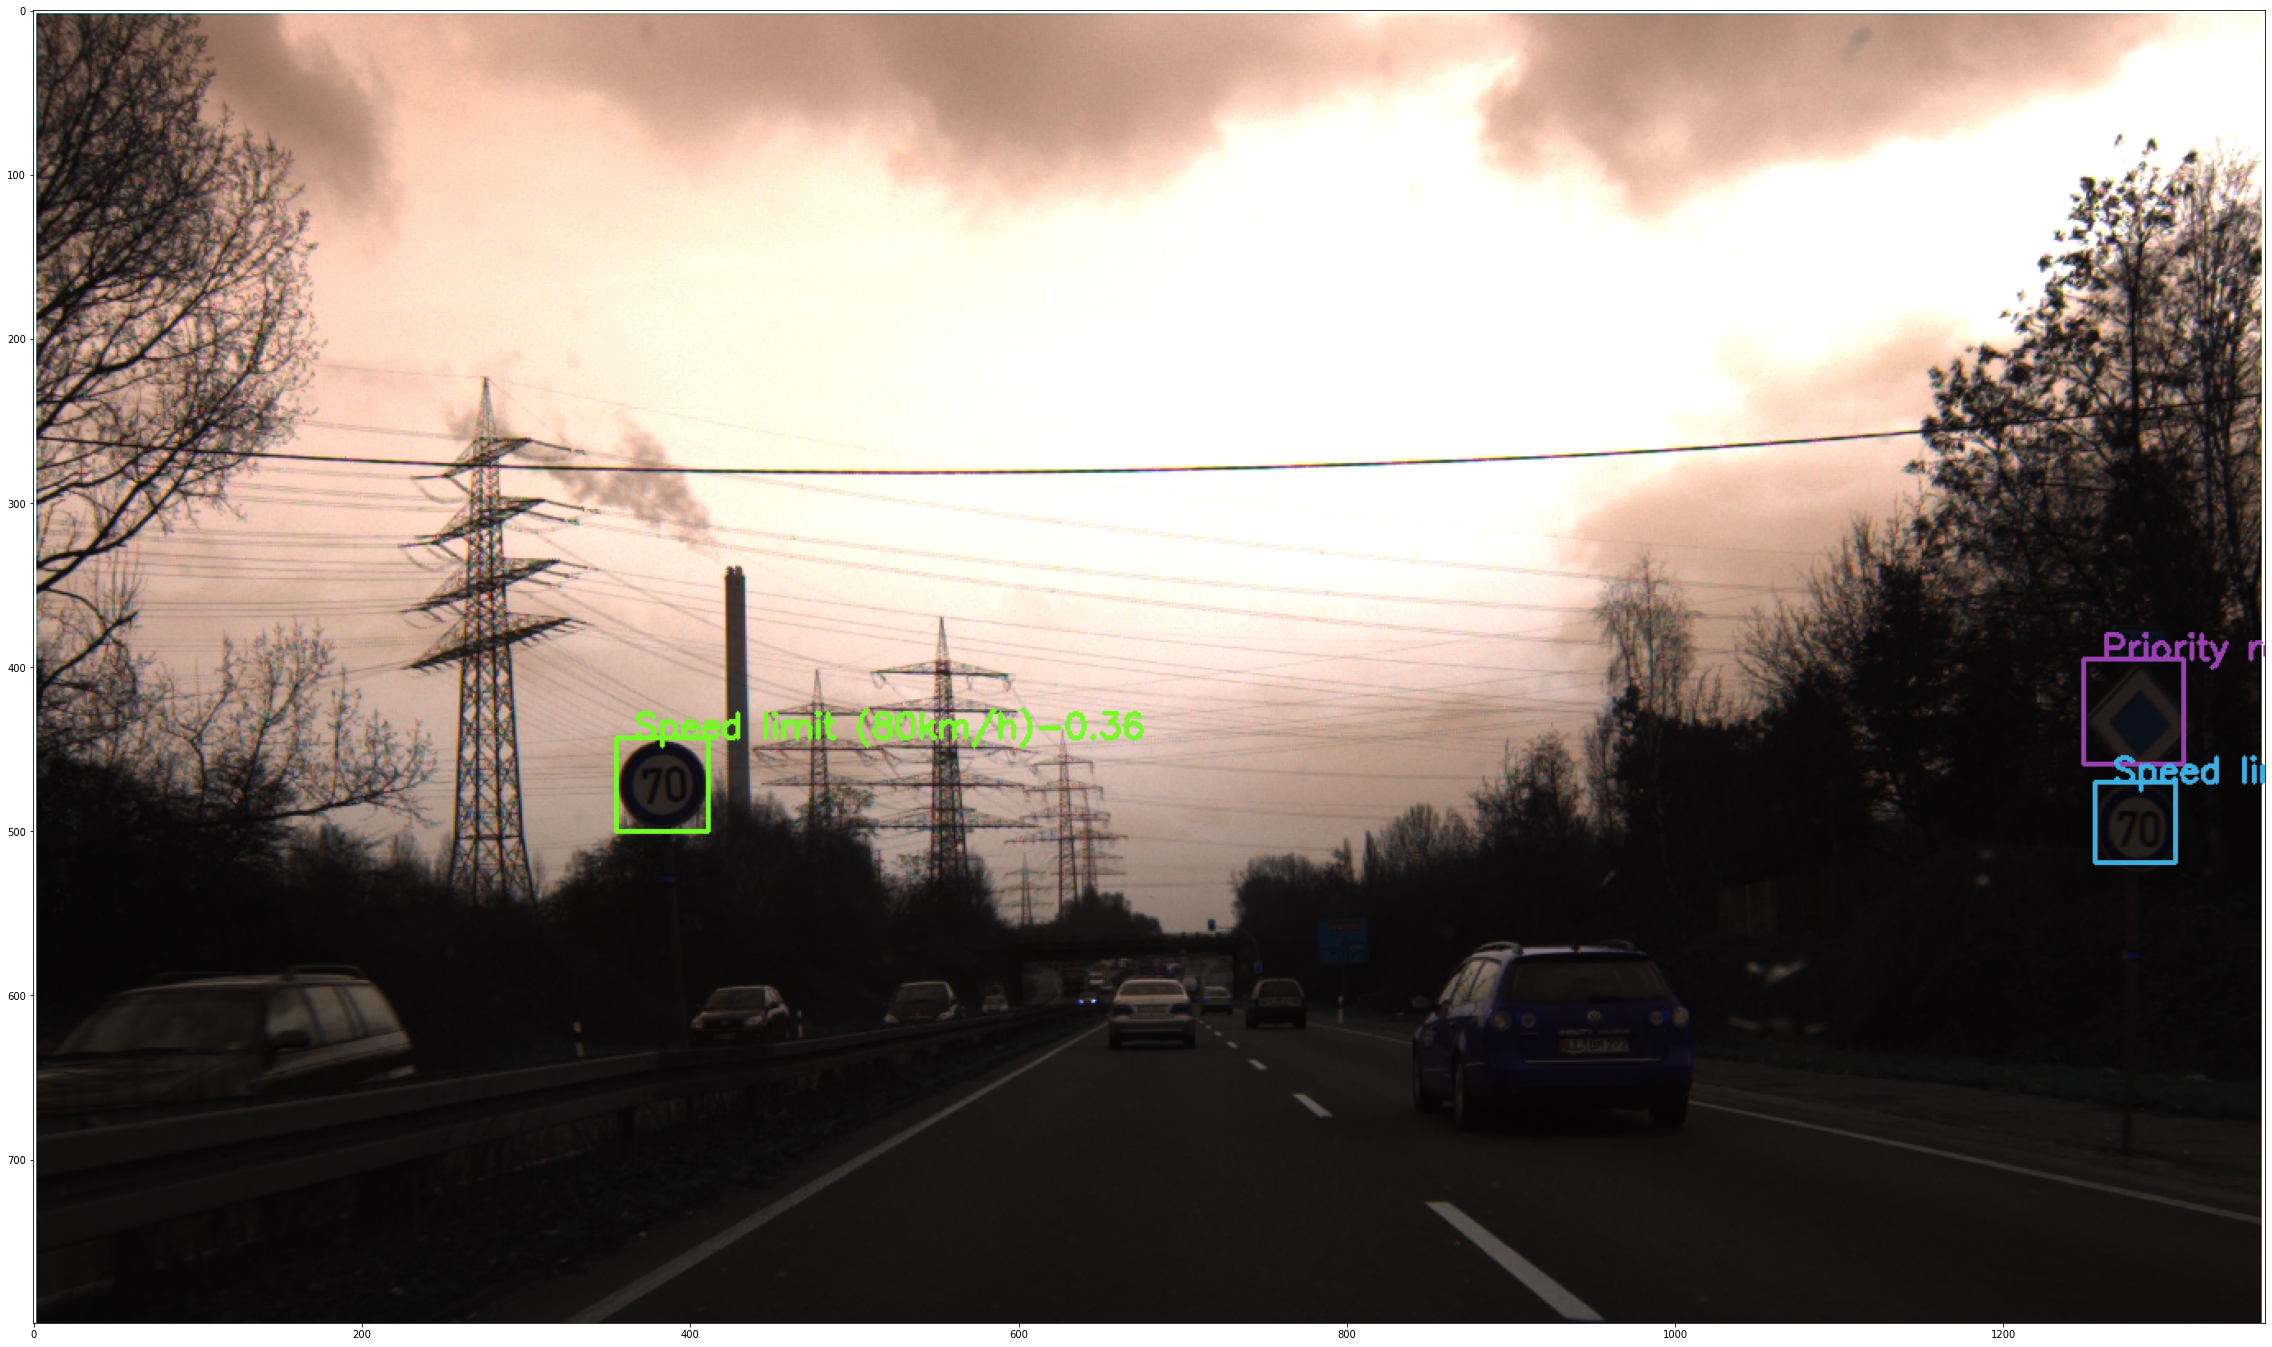

In [87]:
img, _ = dataset_test[99]
showbbox(model, img)